<a href="https://colab.research.google.com/github/Re14m/isk/blob/master/2022_0224_dogs_vs_cats_redux_kernels_edition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
#Google Driveをマウント
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
#Kaggle APIのインストール
!pip install kaggle

In [30]:
#jsonで認証
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 62 bytes


In [31]:
#datasetをDL
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition

 99% 539M/544M [00:06<00:00, 84.1MB/s]
100% 544M/544M [00:06<00:00, 88.3MB/s]
  0% 0.00/111k [00:00<?, ?B/s]
100% 111k/111k [00:00<00:00, 18.8MB/s]
 98% 266M/271M [00:03<00:00, 66.9MB/s]
100% 271M/271M [00:03<00:00, 76.2MB/s]


In [32]:
#dataフォルダを作成
!mkdir -p /content/data/ .

In [33]:
#train.zipを解凍（trainフォルダは自動生成）
!unzip -o /content/train.zip -d /content/data/

#trainフォルダを作り、その中にdogsフォルダ,catsフォルダを作成
!mkdir -p /content/data/train/cats .
!mkdir -p /content/data/train/dogs .

ストリーミング出力は最後の 5000 行に切り捨てられました。
  inflating: /content/data/train/dog.5499.jpg  
  inflating: /content/data/train/dog.55.jpg  
  inflating: /content/data/train/dog.550.jpg  
  inflating: /content/data/train/dog.5500.jpg  
  inflating: /content/data/train/dog.5501.jpg  
  inflating: /content/data/train/dog.5502.jpg  
  inflating: /content/data/train/dog.5503.jpg  
  inflating: /content/data/train/dog.5504.jpg  
  inflating: /content/data/train/dog.5505.jpg  
  inflating: /content/data/train/dog.5506.jpg  
  inflating: /content/data/train/dog.5507.jpg  
  inflating: /content/data/train/dog.5508.jpg  
  inflating: /content/data/train/dog.5509.jpg  
  inflating: /content/data/train/dog.551.jpg  
  inflating: /content/data/train/dog.5510.jpg  
  inflating: /content/data/train/dog.5511.jpg  
  inflating: /content/data/train/dog.5512.jpg  
  inflating: /content/data/train/dog.5513.jpg  
  inflating: /content/data/train/dog.5514.jpg  
  inflating: /content/data/train/dog.5515.jpg  
  inflating:

In [34]:
#trainフォルダの画像をdogsとcatsに分ける
import os
os.chdir('/content/data/train/')

!mv dog.*.jpg dogs/
!mv cat.*.jpg cats/

In [35]:
#test.zipを解凍（testフォルダは自動生成）
!unzip -o /content/test.zip -d /content/data/

#testフォルダを作り、その中にunknownフォルダを作成
!mkdir -p /content/data/test/unknown .

ストリーミング出力は最後の 5000 行に切り捨てられました。
  inflating: /content/data/test/5499.jpg  
  inflating: /content/data/test/55.jpg  
  inflating: /content/data/test/550.jpg  
  inflating: /content/data/test/5500.jpg  
  inflating: /content/data/test/5501.jpg  
  inflating: /content/data/test/5502.jpg  
  inflating: /content/data/test/5503.jpg  
  inflating: /content/data/test/5504.jpg  
  inflating: /content/data/test/5505.jpg  
  inflating: /content/data/test/5506.jpg  
  inflating: /content/data/test/5507.jpg  
  inflating: /content/data/test/5508.jpg  
  inflating: /content/data/test/5509.jpg  
  inflating: /content/data/test/551.jpg  
  inflating: /content/data/test/5510.jpg  
  inflating: /content/data/test/5511.jpg  
  inflating: /content/data/test/5512.jpg  
  inflating: /content/data/test/5513.jpg  
  inflating: /content/data/test/5514.jpg  
  inflating: /content/data/test/5515.jpg  
  inflating: /content/data/test/5516.jpg  
  inflating: /content/data/test/5517.jpg  
  inflating: /content/data

In [36]:
#testフォルダの画像をunknownに移動
os.chdir('/content/data/test/')

!mv *.jpg unknown/

In [37]:
#validationフォルダを作り、その中にdogsフォルダ,catsフォルダを作成
!mkdir -p /content/data/validation/cats .
!mkdir -p /content/data/validation/dogs .

In [38]:
#trainフォルダのcatsフォルダとdogsフォルダをvalidationにコピー
!cp -r /content/data/train/cats /content/data/validation/
!cp -r /content/data/train/dogs /content/data/validation/

In [39]:
!ls /content/data/train/cats | wc -l
!ls /content/data/train/dogs | wc -l
!ls /content/data/validation/cats | wc -l
!ls /content/data/validation/dogs | wc -l
!ls /content/data/test/unknown | wc -l

12500
12500
12500
12500
12500


In [40]:
#ライブラリのインポート
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from keras import optimizers
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Dropout, Flatten, Input, BatchNormalization
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
import numpy as np

In [41]:
# 乱数固定
import keras.backend as K
import tensorflow as tf

np.random.seed(seed=0)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1)

tf.random.set_seed(0)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

In [42]:
# 画像ファイルパス
train_data_dir = "/content/data/train/"
validation_data_dir = "/content/data/validation/"

In [43]:
# モデル条件設定
img_width, img_height = 150, 150
nb_train_samples = 3000
nb_validation_samples = 1000
epochs = 50
batch_size = 32
nb_category = 2

In [44]:
# 画像データのジェネレータ

# 訓練用
train_datagen = ImageDataGenerator(rescale=1. / 255)
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode="categorical")
# 検証用
validation_datagen = ImageDataGenerator(rescale=1. / 255)
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode="categorical")

Found 25000 images belonging to 2 classes.
Found 25000 images belonging to 2 classes.


In [45]:
# モデル定義

# モデルVGG16（not include Top）
input_tensor = Input(shape=(img_width, img_height, 3))
vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=input_tensor)

# モデルTop
top_model = Sequential()
top_model.add(Flatten(input_shape=vgg16.output_shape[1:]))
top_model.add(Dense(256, activation='relu', kernel_initializer='he_normal'))
top_model.add(BatchNormalization())
top_model.add(Dropout(0.5))
top_model.add(Dense(nb_category, activation='softmax'))

# vgg16とtop_modelを連結
model = Model(inputs=vgg16.input, outputs=top_model(vgg16.output))

# layer14までの重みパメータを固定する（訓練で更新しない）
for layer in model.layers[:15]:
    layer.trainable = False

# コールバック

# early_stopping_cb = EarlyStopping(
#    monitor='val_acc', patience=10, verbose=1, mode='max')

# checkpoint_cb = ModelCheckpoint(
#    './{epoch:03d}-{val_acc:.5f}.hdf5', save_best_only=True)

csvlogger_cb = CSVLogger('./history.csv') 

# コンパイル ----------
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.RMSprop(learning_rate=5e-7, decay=5e-5),
              metrics=['accuracy'])

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0   

In [46]:
# 訓練実行
history = model.fit_generator(
      train_generator,
      steps_per_epoch=nb_train_samples // batch_size,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps=nb_validation_samples // batch_size,
      callbacks=[csvlogger_cb])

# モデルを保存
model.save("model.h5")

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


93/93 [==============================] - 24s 242ms/step - loss: 1.3917 - accuracy: 0.4563 - val_loss: 0.7933 - val_accuracy: 0.4950
Epoch 2/50
93/93 [==============================] - 22s 238ms/step - loss: 1.2757 - accuracy: 0.4973 - val_loss: 0.7322 - val_accuracy: 0.5706
Epoch 3/50
93/93 [==============================] - 22s 240ms/step - loss: 1.0935 - accuracy: 0.5585 - val_loss: 0.7226 - val_accuracy: 0.6008
Epoch 4/50
93/93 [==============================] - 22s 239ms/step - loss: 0.9962 - accuracy: 0.5830 - val_loss: 0.7063 - val_accuracy: 0.6240
Epoch 5/50
93/93 [==============================] - 22s 240ms/step - loss: 0.9180 - accuracy: 0.6022 - val_loss: 0.6068 - val_accuracy: 0.7026
Epoch 6/50
93/93 [==============================] - 22s 238ms/step - loss: 0.8556 - accuracy: 0.6230 - val_loss: 0.6216 - val_accuracy: 0.6966
Epoch 7/50
93/93 [==============================] - 22s 238ms/step - loss: 0.8265 - accuracy: 0.6465 - val_loss: 0.5567 - val_accuracy: 0.7389
Epoch 8/50

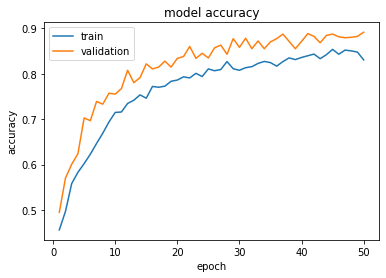

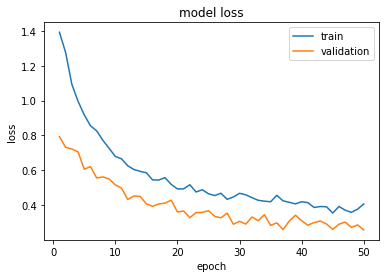

In [47]:
# 訓練履歴をグラフで可視化
import matplotlib.pyplot as plt
import pandas as pd

history = pd.read_csv('history.csv')
history_rows = len(history)

# accuracy
plt.plot(range(1, history_rows + 1), history['accuracy']) # training
plt.plot(range(1, history_rows + 1), history['val_accuracy']) # validation
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

# loss
plt.plot(range(1, history_rows + 1), history['loss'])
plt.plot(range(1, history_rows + 1), history['val_loss'])
plt.title('model accuracy')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

In [48]:
# モデル読み込み（＠保存ファイルより再読み込み用）
from keras.models import load_model
model = load_model("./model.h5")

In [ ]:
#---評価用データで検証----

In [49]:
#ライブラリのインポート
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from keras import optimizers
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Dropout, Flatten, Input, BatchNormalization
from keras.models import Model, Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
import pandas as pd
import numpy as np
import os

In [50]:
# テストデータで予測実行
test_data_dir = "/content/data/test/"
img_width, img_height = 150, 150
nb_test_samples = 30
batch_size = 1
nb_category = 2

# 画像データのジェネレータ（テスト用）
test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
        test_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

# 分類予測
pred = model.predict_generator(
        test_generator,
        steps=nb_test_samples,
        verbose=1)

Found 12500 images belonging to 1 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


30/30 [==============================] - 1s 21ms/step


In [51]:
# テストデータの予測結果

labels = ['cat', 'dog']
# データ0～14 -> Cat画像
# データ15～29 -> Dog画像

print("*** test data [cat] *****")
for i in pred[0:15]:
    cls = np.argmax(i)
    score = np.max(i)
    print("pred: {}  score = {:.3f}".format(labels[cls], score))

print("-" * 30)

print("*** test data [dog] *****")
for i in pred[15:30]:
    cls = np.argmax(i)
    score = np.max(i)
    print("pred: {}  score = {:.3f}".format(labels[cls], score))

*** test data [cat] *****
pred: dog  score = 0.997
pred: cat  score = 0.974
pred: cat  score = 0.606
pred: dog  score = 0.974
pred: dog  score = 0.997
pred: cat  score = 0.910
pred: cat  score = 0.992
pred: dog  score = 0.945
pred: cat  score = 0.530
pred: cat  score = 1.000
pred: cat  score = 0.998
pred: cat  score = 0.970
pred: cat  score = 0.999
pred: cat  score = 0.999
pred: cat  score = 0.992
------------------------------
*** test data [dog] *****
pred: dog  score = 1.000
pred: dog  score = 0.966
pred: cat  score = 0.999
pred: cat  score = 0.976
pred: cat  score = 0.990
pred: dog  score = 0.966
pred: cat  score = 0.580
pred: cat  score = 1.000
pred: cat  score = 0.802
pred: cat  score = 0.943
pred: dog  score = 0.824
pred: cat  score = 0.996
pred: cat  score = 0.977
pred: dog  score = 0.937
pred: cat  score = 0.500


In [52]:
import pandas as pd
import numpy as np
import cv2
from tensorflow import keras
from keras import backend as K
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.models import load_model

K.set_learning_phase(1) # set learning phase

/usr/local/lib/python3.7/dist-packages/keras/backend.py:450: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


In [53]:
# *************************************************
# Gradient-weighted Class Activation Mapping  *****
#**************************************************

# 呼び出し用関数
def Grad_Cam(input_model, x, layer_name):

    # 前処理
    X = np.expand_dims(x, axis=0)
    X = X.astype('float32')
    preprocessed_input = X / 255.0

    # 予測クラス算出
    predictions = model.predict(preprocessed_input)
    class_idx = np.argmax(predictions[0])
    class_output = model.output[:, class_idx]

    #  勾配取得
    conv_output = model.get_layer(layer_name).output
    grads = K.gradients(class_output, conv_output)[0]
    gradient_function = K.function([model.input], [conv_output, grads])
    output, grads_val = gradient_function([preprocessed_input])
    output, grads_val = output[0], grads_val[0]

    # 重み平均化、cam算出
    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)

    # ヒートマップ合成
    w = x.shape[0]
    h = x.shape[1]
    cam = cv2.resize(cam, (w, h), cv2.INTER_LINEAR)
    
    cam = np.maximum(cam, 0)
    if cam.max() == 0: # 色付け不可（ブルー画像になる）
      return None
    
    cam = cam / cam.max()

    jetcam = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    jetcam = cv2.cvtColor(jetcam, cv2.COLOR_BGR2RGB)
    jetcam = (np.float32(jetcam) + x / 2)

    return jetcam

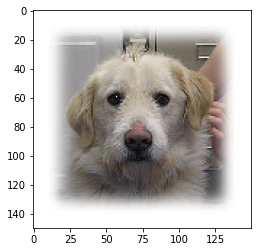

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide


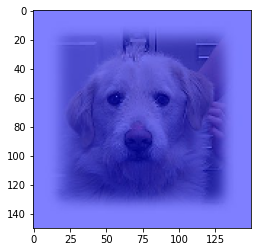

In [57]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

# 画像用
from keras.preprocessing.image import array_to_img, img_to_array, load_img
# モデル読み込み用
from keras.models import load_model
# Grad−CAM計算用
from tensorflow.keras import models
import tensorflow as tf

IMAGE_SIZE  = (150, 150)
def grad_cam(input_model, x, layer_name):
    """
    Args: 
        input_model(object): モデルオブジェクト
        x(ndarray): 画像
        layer_name(string): 畳み込み層の名前
    Returns:
        output_image(ndarray): 元の画像に色付けした画像
    """

    # 画像の前処理
    # 読み込む画像が1枚なため、次元を増やしておかないとmode.predictが出来ない
    X = np.expand_dims(x, axis=0)
    preprocessed_input = X.astype('float32') / 255.0    

    grad_model = models.Model([input_model.inputs], [input_model.get_layer(layer_name).output, input_model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(preprocessed_input)
        class_idx = np.argmax(predictions[0])
        loss = predictions[:, class_idx]

    # 勾配を計算
    output = conv_outputs[0]
    grads = tape.gradient(loss, conv_outputs)[0]

    gate_f = tf.cast(output > 0, 'float32')
    gate_r = tf.cast(grads > 0, 'float32')

    guided_grads = gate_f * gate_r * grads

    # 重みを平均化して、レイヤーの出力に乗じる
    weights = np.mean(guided_grads, axis=(0, 1))
    cam = np.dot(output, weights)

    # 画像を元画像と同じ大きさにスケーリング
    cam = cv2.resize(cam, IMAGE_SIZE, cv2.INTER_LINEAR)
    # ReLUの代わり
    cam  = np.maximum(cam, 0)
    # ヒートマップを計算
    heatmap = cam / cam.max()

    # モノクロ画像に疑似的に色をつける
    jet_cam = cv2.applyColorMap(np.uint8(255.0*heatmap), cv2.COLORMAP_JET)
    # RGBに変換
    rgb_cam = cv2.cvtColor(jet_cam, cv2.COLOR_BGR2RGB)
    # もとの画像に合成
    output_image = (np.float32(rgb_cam) + x / 2)  

    return output_image

from PIL import Image

model = load_model("model.h5")
x = img_to_array(load_img('/content/data/test/unknown/3.jpg', target_size=(150,150)))
arr1 = array_to_img(x)
#plt.imshow(x)
plt.imshow(arr1)
plt.show()


image1 = grad_cam(model, x, 'block5_conv2') 
arr2 = array_to_img(image1, scale=True)
plt.imshow(arr2)
plt.show()